# Binary Random Variables

This is a problem that we come across a lot in stats. It's about as simple as it gets, and yet it is still quite subtle and easy to get wrong.

Imagine we have a single random variable that is either 0, or 1. p is the probability that the random variable is 1. I draw from this distribution n times and measure k, the number of 1s that I get. For instance tossing a (potentially bias) coin n times, how many times do I pull a head.

Let's explore all the facets of this problem. In particular I want to answer:

- What is the distribution for k?
- What is the cumulative distribution for k?
- What is the mean and variance of this distribution?
- How quickly do sample means and variances converge to their theoretical values?
- What are the confidence intervals on this distribution?
- How well is this distribution approximated by a normal distribution?

And then get to significance tests:

- Imagine I have two such processes. What is the best test of the null hypothesis that p_1 = p_2? Do these tests go wrong sometimes?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.style.use('../../default.mplstyle')

### Fake data

This is fairly straight forward to generate.

In [4]:
def random_binomial(p, n):
    """
    Return the number of sucsessful trials of a binary random variable,
    where p in the probability of sucsess, and n is the number of trials.
    """
    return sum(np.random.random() < p for _ in range(n))

In [5]:
def distribution(f, trials, *args, **kwargs):
    """
    Takes a random variable function and runs it multiple times and returns the distribution.
    Will work well only with discrete outcomes.
    """
    
    data = [f(*args, **kwargs) for _ in range(trials)]
    return {k: data.count(k) for k in set(data)}

Now let's verify the theoretical distribution for k.

We should have:

$$f(k) = \frac{n!}{k!(n-k)!}p(1-p)$$

In [6]:
from math import factorial, gamma

In [7]:
def f(k, n, p):
    return factorial(n)/(factorial(k)*factorial(n-k))*p**k*(1-p)**(n-k)

Note that we can make a continous version of this function, that should have the same values as the discrete one for integers, this is really only for visualisation perposes.

In [8]:
def f_cont(k, n, p):
    return gamma(n + 1)/(gamma(k + 1)*gamma(n - k + 1))*p**k*(1-p)**(n-k)

In [27]:
k = np.random.randint(0, 20)
n = k + np.random.randint(0, 20)
p = np.random.random()
for _ in range(10):
    try:
        assert np.round(f(k, n, p)*1000) == np.round(f_cont(k, n, p)*1000)
    except:
        print('didnt match for values:')
        print(k, n, p)
        print(f(k, n, p), f_cont(k, n, p))

Now let's do some trials with some differening ps and ns. Let's vary p and n systematically and plot on a grid, along with the predictions of the equations.

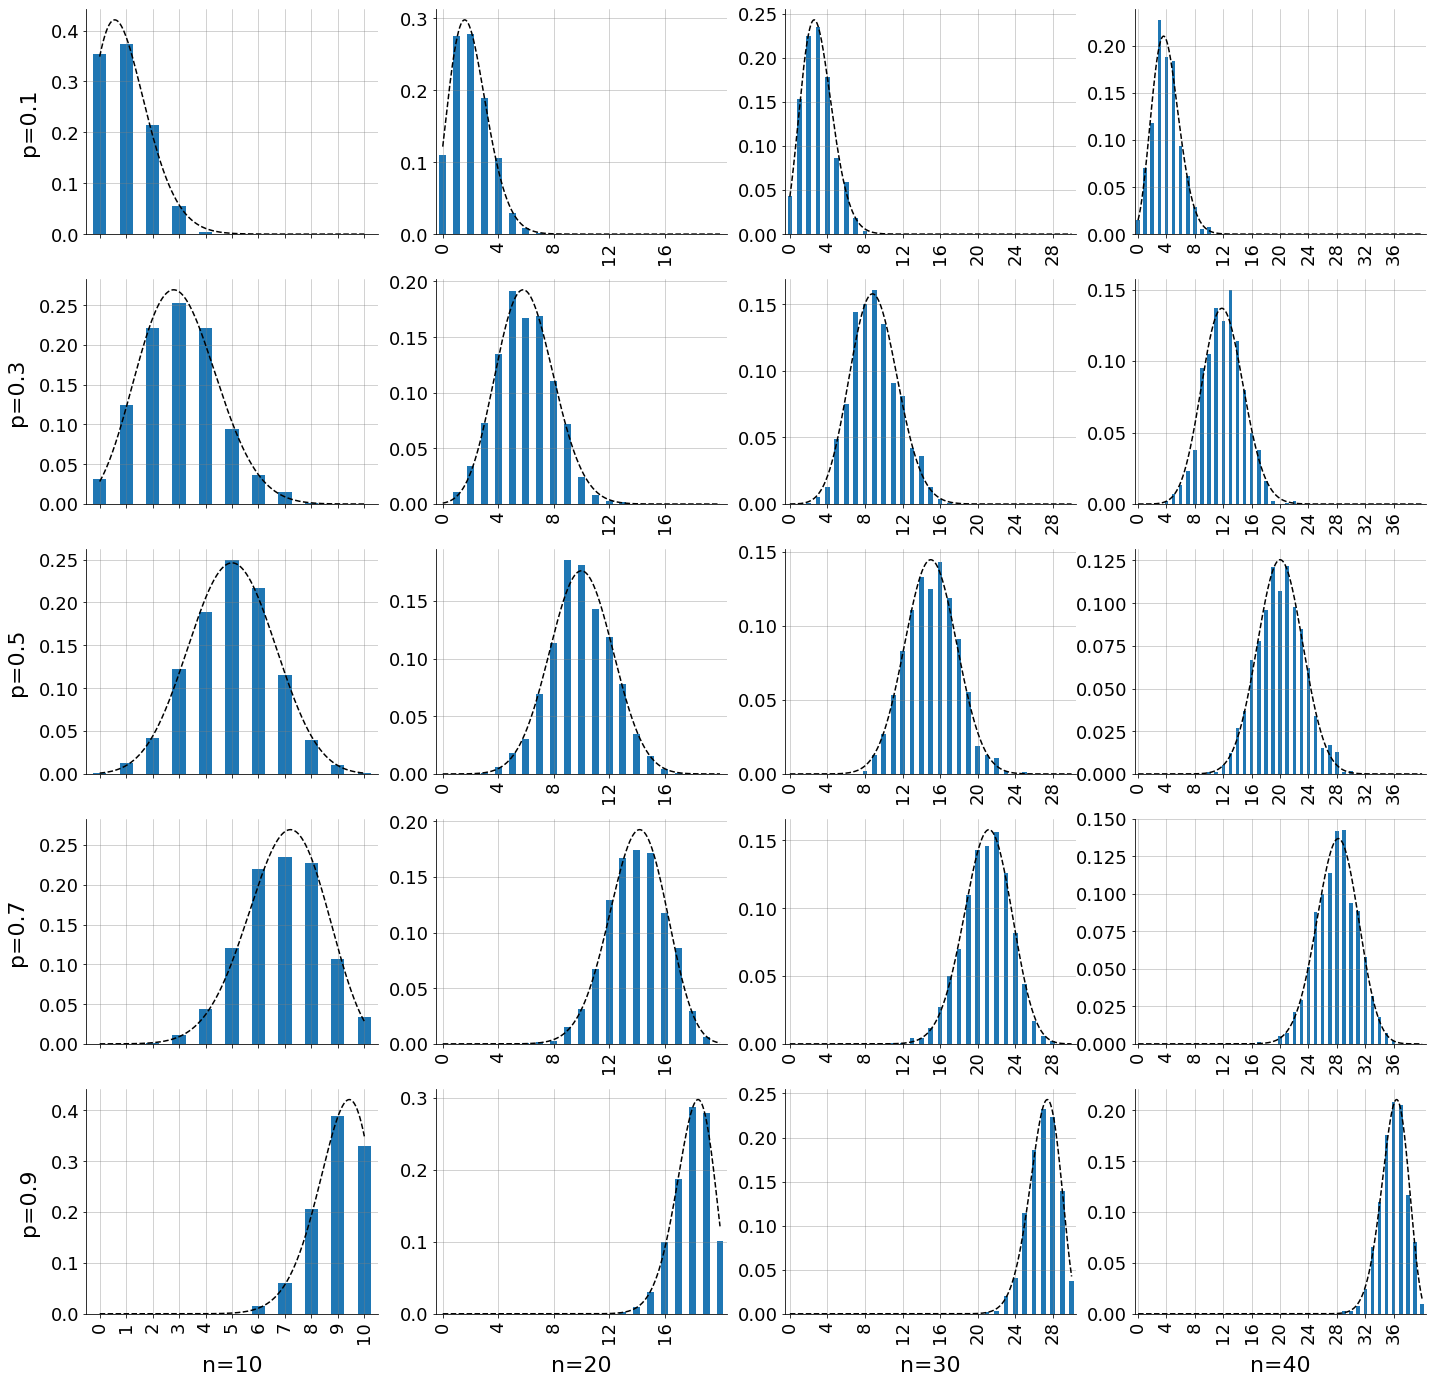

In [33]:
ps = np.linspace(0.1, 0.9, 5)
ns = [10*n for n in range(1, 5)]

_, AX = plt.subplots(len(ps), len(ns), figsize=(24, 24))
trials = 1001

for i, p in enumerate(ps):
    for j, n in enumerate(ns):
        data = pd.Series(distribution(random_binomial, trials, p=p, n=n))
        data = data.reindex(range(n + 1)).fillna(0)
        data /= data.sum()
        ax = AX[i][j]
        data.plot.bar(ax=ax)
        
        if i != len(ps) - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('n={}'.format(n))
            
        if j == 0:
            ax.set_ylabel('p={:.1f}'.format(p))
            
        if n > 10:
            ax.set_xticks([i for i in range(n) if i%4 == 0])
            ax.set_xticklabels([i for i in range(n) if i%4 == 0])

        # Add a line for the continous distribution for comparison
        xs = np.linspace(0, n, 10001)
        ys = [f_cont(x, n, p) for x in xs]
        ax.plot(xs, ys, '--', color='black')

The fit is pretty good in all cases.

### Relation to the normal distribution

Let's plot the theortitical binomial distribution against the normal distribution. How good of an approximation is it.

Clearly the normal distribution is continous, and it can take on any value, so in this regard it will not fit exactly. Drawing some examples may help to gain some intuation.

Let's simply plot both distributions for a combination of ps and ns.

In [62]:
from scipy.stats import norm

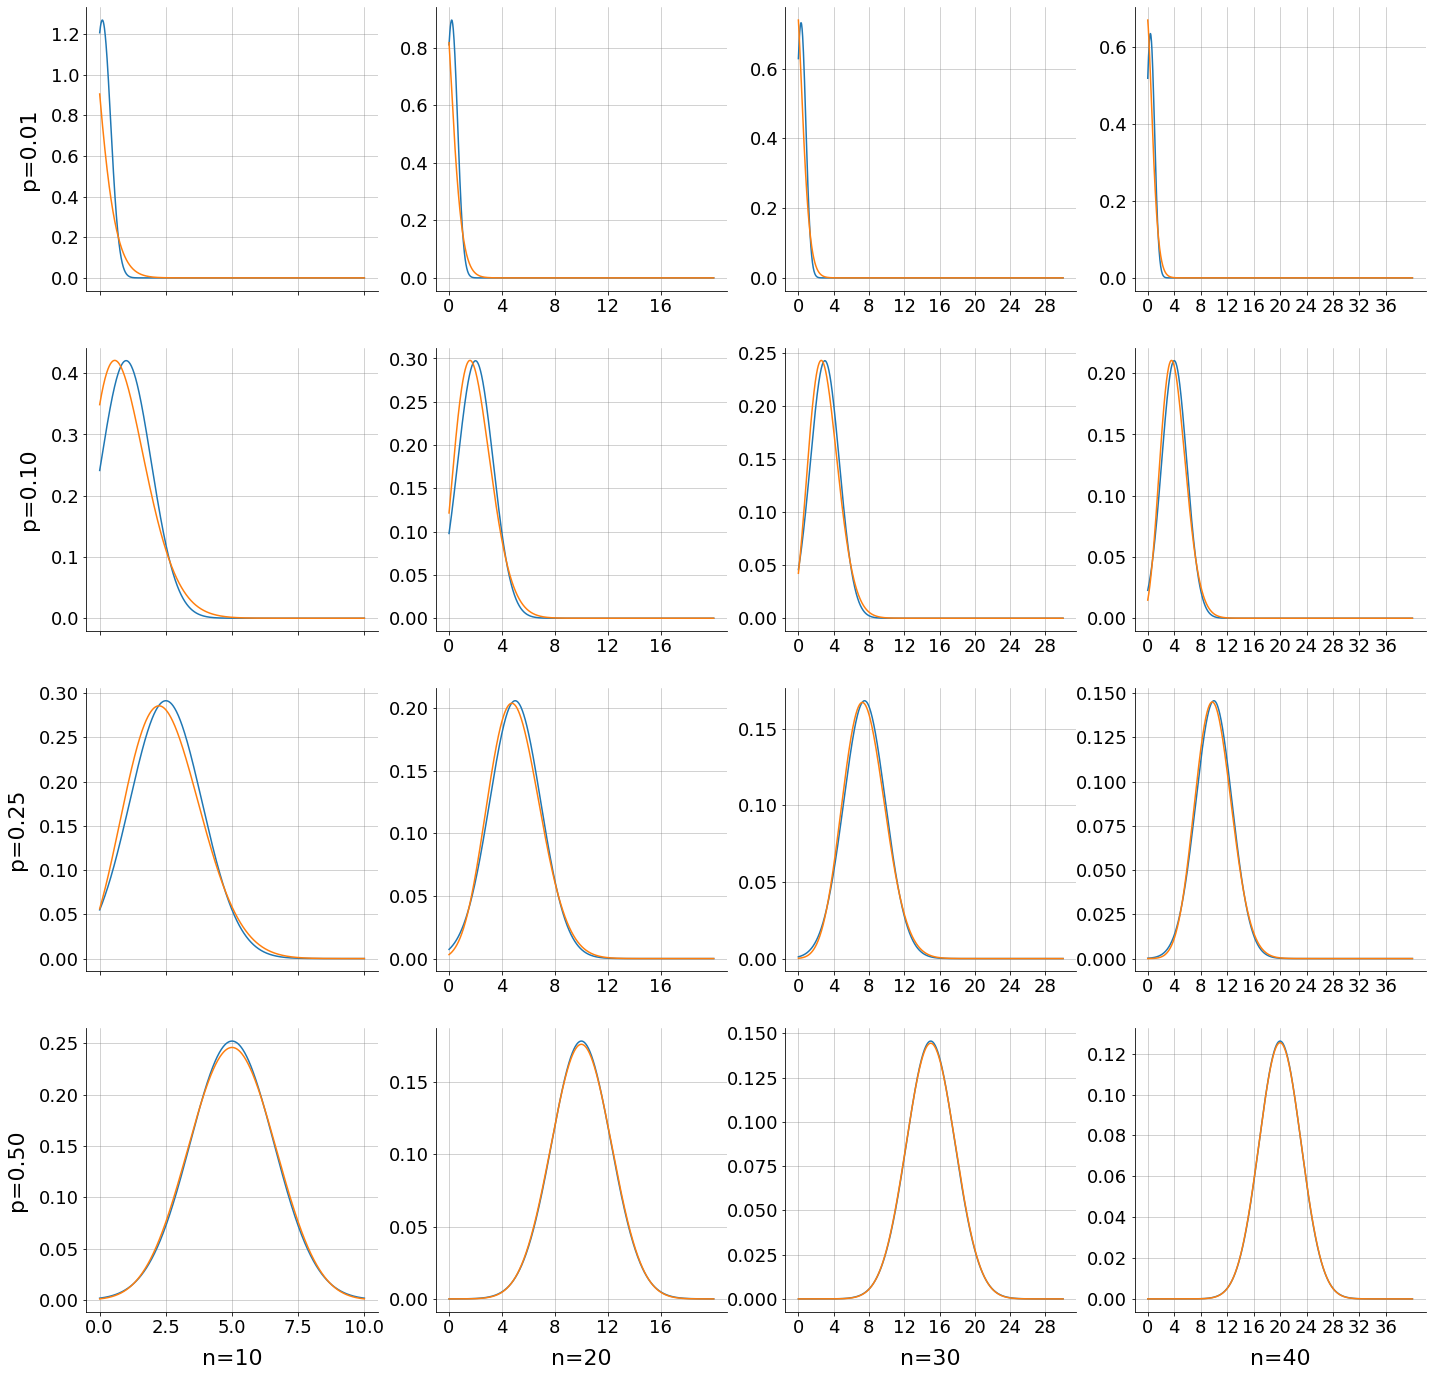

In [88]:
ps = [0.01, 0.1, 0.25, 0.5]
ns = [10*n for n in range(1, 5)]

_, AX = plt.subplots(len(ps), len(ns), figsize=(24, 24))


for i, p in enumerate(ps):
    for j, n in enumerate(ns):

        ax = AX[i][j]
        
        xs = np.linspace(0, n, 1001)
        
        ys_normal = norm.pdf(xs, n*p, np.sqrt(n*p*(1-p)) )
        ys_binomial = [f_cont(x, n, p) for x in xs]

        ax.plot(xs, ys_normal)
        ax.plot(xs, ys_binomial)
        
        if i != len(ps) - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('n={}'.format(n))
            
        if j == 0:
            ax.set_ylabel('p={:.2f}'.format(p))
            
        if n > 10:
            ax.set_xticks([i for i in range(n) if i%4 == 0])
            ax.set_xticklabels([i for i in range(n) if i%4 == 0])




So they do match up quite nicely by eyeball. But for small n there is definitely a mismatch, and for ps that are close to zero (or one).

### Mean and Variance

Intuatively the mean of the binomial distribution is p. The sample mean converges to the actual mean. The variance of the distribution is $n(p)(1-p)$

Now let's verify this, I also want to look at how the sample mean converges to the actual mean, and likewise for the variance.

I want to do a single version of the trial each time, so one bias coin flip each time and keep a running mean and variance.

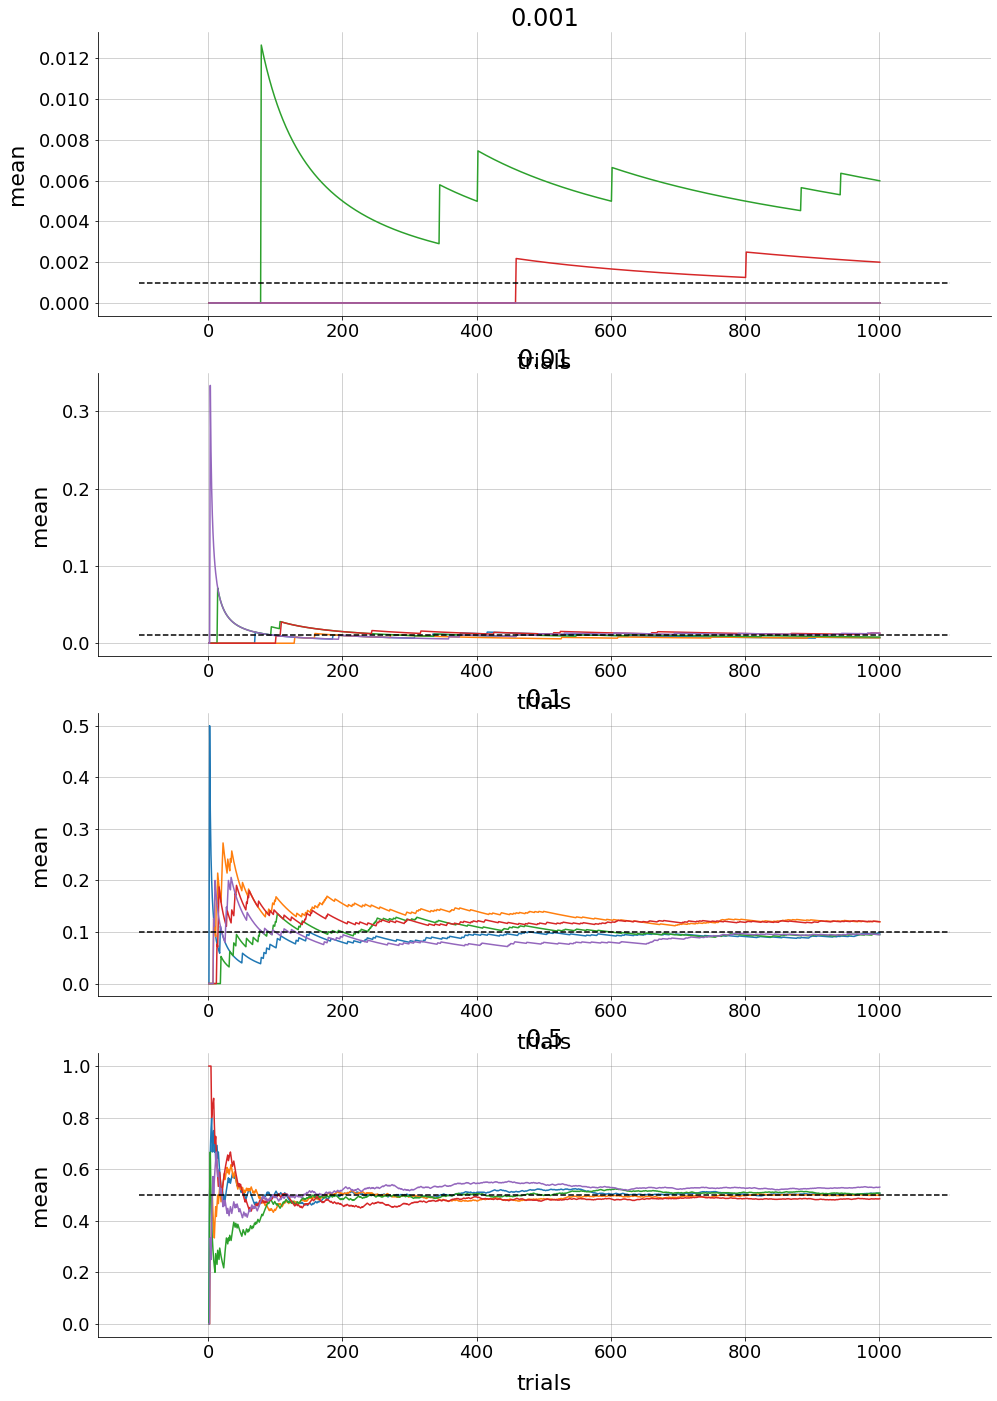

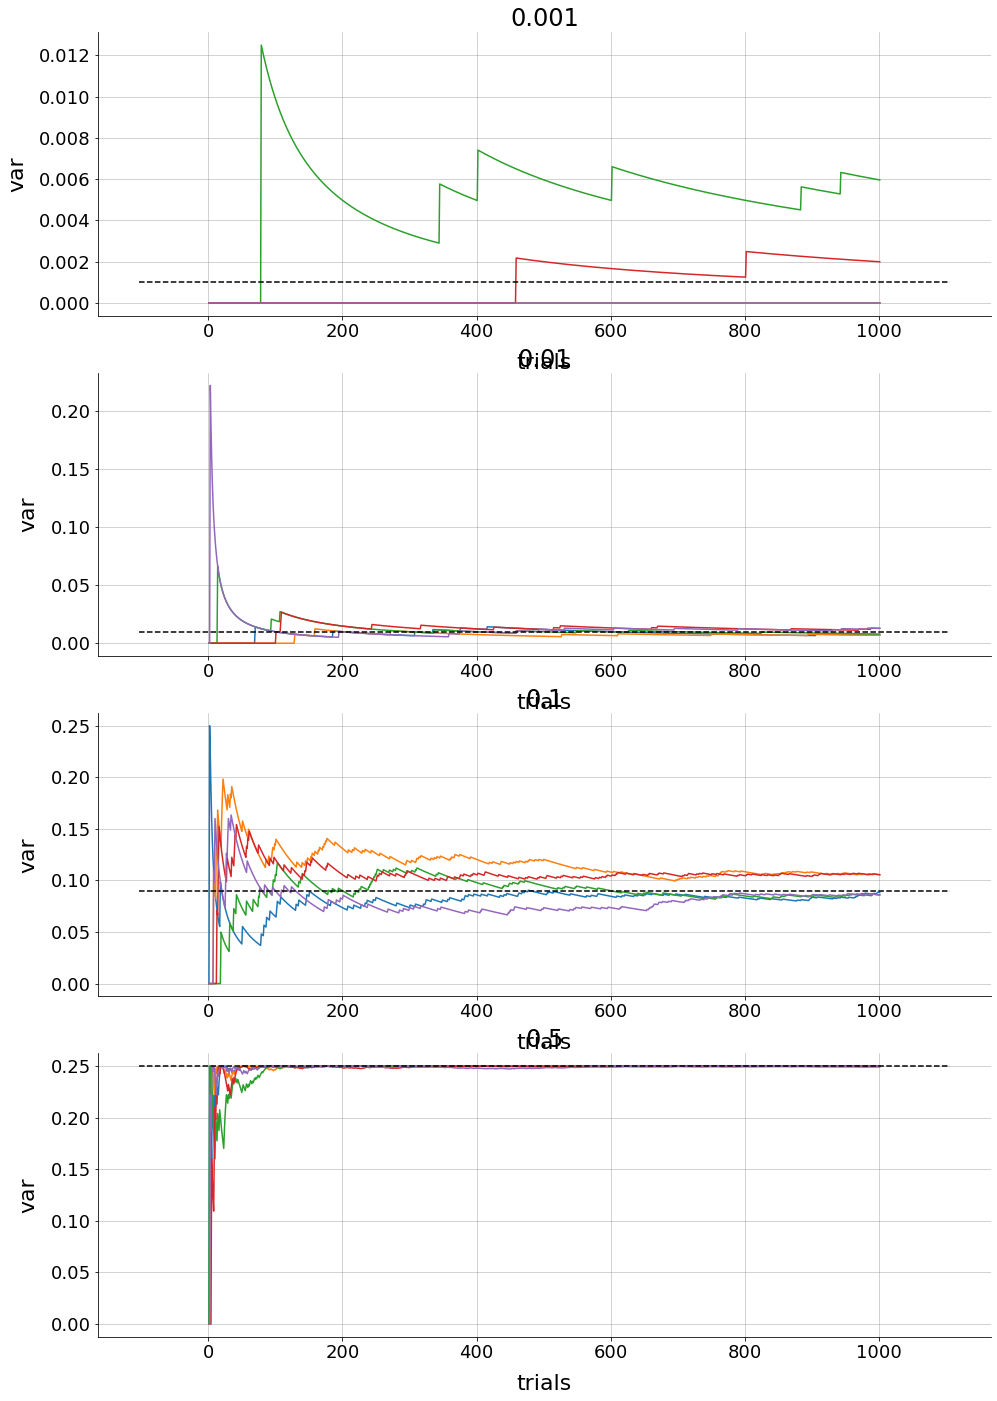

In [61]:
trials = 1001
repeats = 5

_, AX1 = plt.subplots(4, 1, figsize=(16, 24))
_, AX2 = plt.subplots(4, 1, figsize=(16, 24))

# I won't do greater than half because of the symmetry of the problem
for i,p in enumerate([0.001, 0.01, 0.1, 0.5]):
    ax1 = AX1[i]
    ax2 = AX2[i]
    
    mean_theory = p
    var_theory = p*(1 - p)

    for r in range(repeats):
        running_means = []
        running_total = 0
        running_vars = []
        for i in range(trials):

            # Do one trial, it's so trivial I won't make a function for it.
            r = int(np.random.random() < p)
            running_total += r
            running_mean = running_total/(i+1)
            running_means.append(running_mean)

            # Variance is mean of squares minus square of means.
            # Luckily both 1 and zero square to themselves so the mean squared is the
            # same as the mean.
            var = running_mean - running_mean**2
            running_vars.append(var)


        ax1.plot(range(1, trials + 1), running_means)

        ax2.plot(range(1, trials + 1), running_vars)

    ax1.plot(ax.get_xlim(), [p]*2, '--', color='black')
    ax1.set_xlabel('trials')
    ax1.set_ylabel('mean')
    ax1.set_title(p)
    
    ax2.plot(ax.get_xlim(), [var_theory]*2, '--', color='black')
    ax2.set_xlabel('trials')
    ax2.set_ylabel('var')
    ax2.set_title(p)

### Significance Tests

Let's look at some significance tests. We have two random processes which make random trials with probability of sucess of $p_1$ and $p_2$ respectively. The null hypothesis is that $p_1=p_2$. We then want a p value for this null hypothesis.

What tests could we use:

- T-test (in theory shouldn't work in general, but might do well enough for large trials).
- g-test (this is favoured these days)
- chi-squared
- Fisher exact test.

For all of these it is better to return the data than the means, although these distributions are entirely summarised by their means.

In [9]:
def generate_data(p, n):
    return [int(np.random.random() < p) for _ in range(n)]

In [10]:
def base_var_data(p1, p2, n):
    base = generate_data(p1, n)
    variant = generate_data(p2, n)
    return base, variant

Now we have this data let's run a variaty of tests on them.

In [11]:
from scipy.stats import ttest_ind

In [12]:
def ttest(a, b):
    return ttest_ind(a, b, equal_var=False).pvalue

In [13]:
from scipy.stats import chi2_contingency

In [14]:
def gtest(a, b):
    obs = [[a.count(0), a.count(1)],
       [b.count(0), b.count(1)]
      ]
    return chi2_contingency(obs, lambda_ = 'log-likelihood')[1]

In [15]:
def chisquared(a, b):
    obs = [[a.count(0), a.count(1)],
           [b.count(0), b.count(1)]
          ]
    return chi2_contingency(obs)[1]

In [41]:
from scipy.stats import fisher_exact

In [42]:
def fisher_exact_test(a, b):
    obs = [[a.count(0), a.count(1)],
       [b.count(0), b.count(1)]
      ]
    return fisher_exact(obs)[1]

In [49]:
a, b = base_var_data(0.5, 0.5, 200)
ttest(a, b), gtest(a, b), chisquared(a, b), fisher_exact_test(a, b)

(0.07044506647128126,
 0.08699329067933272,
 0.08719575858576835,
 0.08706368240573684)

Now let's investigate a few things. We want our p-values to be uniform if we have no difference. Let's eyeball this, or we could test this with yet another test!

In [19]:
from tqdm.notebook import tqdm

In [20]:
def p_value_dist(test, p1, p2, n, reps):
    data = []
    for _ in tqdm(range(reps)):
        a, b = base_var_data(p1, p2, n)
        data.append(test(a, b))
    return data

Let's do a few tests. Try a small value of p and a small n. Then a reasonable value of p with a small n. Then a small p with a big n, then one that is OK in both. In each case make the null hypothesis true. We are checking that the false positive rate is about right.

In [68]:
tests = [ttest, gtest, chisquared, fisher_exact_test]

In [69]:
reps = 1000

In [78]:
ps = [0.05, 0.3]
ns = [80, 1000]

In [79]:
# 10% positive rate
summary_all = []
alpha = 0.1
for test in tests:
    print(test.__name__)
    for p in ps:
        print('p = {}'.format(p))
        for n in ns:

            print('n = {}'.format(n))
            summary = {}
            data = p_value_dist(test, p, p, n, reps)
            positive_rate = np.mean([p < alpha for p in data])
            summary['p'] = p
            summary['n'] = n
            summary['false positive'] = positive_rate
            summary['test_name'] = test.__name__
            summary_all.append(summary)

        df_null = pd.DataFrame(summary_all)

df_null = pd.DataFrame(summary_all).set_index(['test_name', 'p', 'n']).sort_index().unstack(0)

ttest
p = 0.05
n = 80



n = 1000



p = 0.3
n = 80



n = 1000



gtest
p = 0.05
n = 80



n = 1000



p = 0.3
n = 80



n = 1000



chisquared
p = 0.05
n = 80



n = 1000



p = 0.3
n = 80



n = 1000



fisher_exact_test
p = 0.05
n = 80



n = 1000



p = 0.3
n = 80



n = 1000


In [80]:
df_null

false positive                                
test_name     chisquared fisher_exact_test  gtest  ttest
p    n                                                  
0.05 80            0.040             0.041  0.035  0.104
     1000          0.081             0.080  0.074  0.100
0.30 80            0.061             0.080  0.078  0.100
     1000          0.082             0.101  0.113  0.096

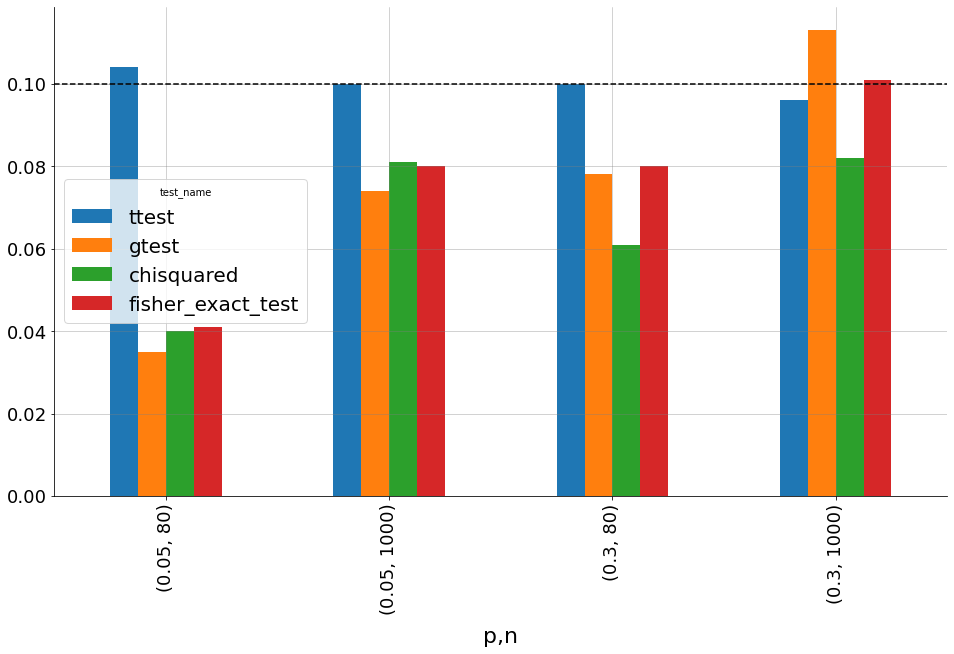

In [88]:
ax = df_null['false positive'][[t.__name__ for t in tests]].plot.bar()
ax.plot(ax.get_xlim(), [alpha]*2, '--', color='black')

So they all do a quite badly for small p and small n by the look of it. Interesting. Otherwise they do sort of equally well in each case.

Now what about their power to detect an actual change in the data? Let's do the same as above, except now I add an extra loop for p2, which I give two different values.

In [82]:
# 10% positive rate
summary_all = []
alpha = 0.1
for test in tests:
    print(test.__name__)
    for p1 in ps:
        for dp in [1.01, 1.3]:
            p2 = p1*dp
            print('p1 = {}'.format(p1))
            print('p2 = {}'.format(p2))            
            for n in ns:
                print('n = {}'.format(n))
                summary = {}
                data = p_value_dist(test, p1, p2, n, reps)

                positive_rate = np.mean([p < alpha for p in data])
                summary['p1'] = p1
                summary['p2'] = p2
                summary['n'] = n
                summary['false positive'] = positive_rate
                summary['test_name'] = test.__name__

                summary_all.append(summary)

df_not_null = pd.DataFrame(summary_all).set_index(['test_name', 'n', 'p1', 'p2']).sort_index().unstack(0)

ttest
p1 = 0.05
p2 = 0.0505
n = 80



n = 1000



p1 = 0.05
p2 = 0.065
n = 80



n = 1000



p1 = 0.3
p2 = 0.303
n = 80



n = 1000



p1 = 0.3
p2 = 0.39
n = 80



n = 1000



gtest
p1 = 0.05
p2 = 0.0505
n = 80



n = 1000



p1 = 0.05
p2 = 0.065
n = 80



n = 1000



p1 = 0.3
p2 = 0.303
n = 80



n = 1000



p1 = 0.3
p2 = 0.39
n = 80



n = 1000



chisquared
p1 = 0.05
p2 = 0.0505
n = 80



n = 1000



p1 = 0.05
p2 = 0.065
n = 80



n = 1000



p1 = 0.3
p2 = 0.303
n = 80



n = 1000



p1 = 0.3
p2 = 0.39
n = 80



n = 1000



fisher_exact_test
p1 = 0.05
p2 = 0.0505
n = 80



n = 1000



p1 = 0.05
p2 = 0.065
n = 80



n = 1000



p1 = 0.3
p2 = 0.303
n = 80



n = 1000



p1 = 0.3
p2 = 0.39
n = 80



n = 1000


Maybe break up the plots? There are too many things to look at?

In [83]:
df_not_null

false positive                                
test_name            chisquared fisher_exact_test  gtest  ttest
n    p1   p2                                                   
80   0.05 0.0505          0.044             0.054  0.054  0.120
          0.0650          0.037             0.072  0.070  0.139
     0.30 0.3030          0.063             0.070  0.082  0.081
          0.3900          0.286             0.282  0.275  0.338
1000 0.05 0.0505          0.084             0.090  0.073  0.106
          0.0650          0.379             0.386  0.373  0.403
     0.30 0.3030          0.094             0.090  0.106  0.079
          0.3900          0.995             0.993  0.999  0.998

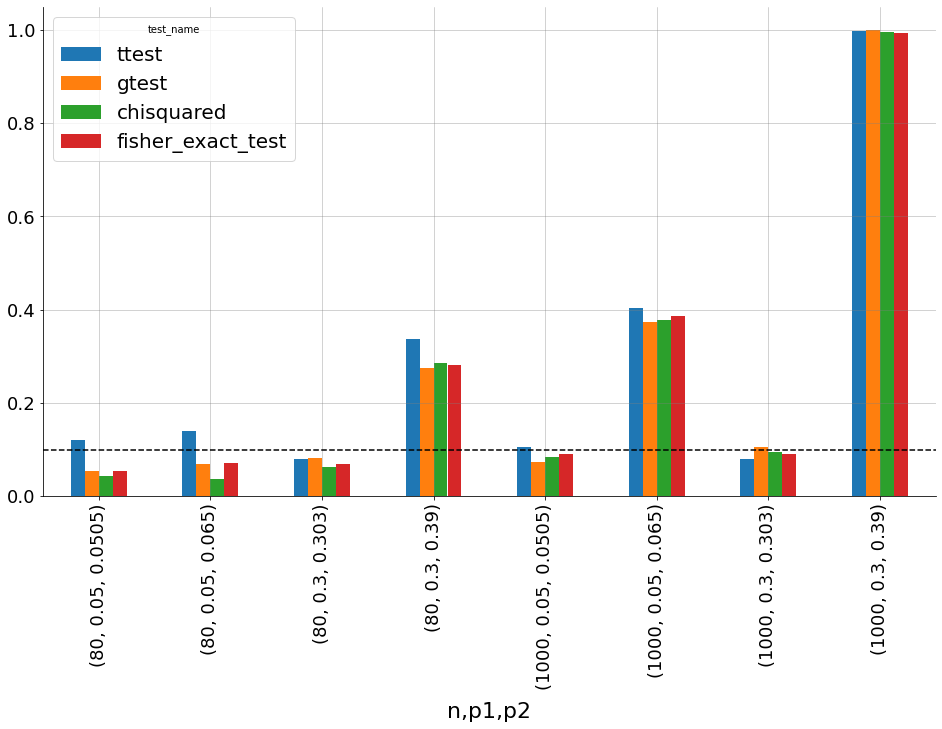

In [89]:
ax = df_not_null['false positive'][[t.__name__ for t in tests]].plot.bar()
ax.plot(ax.get_xlim(), [alpha]*2, '--', color='black')

The tests are all kind of the same on this kind of data!